In [1]:
from tqdm import tqdm
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import median_absolute_error

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression

c:\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
invoices = pd.read_csv('data/invoices.csv').set_index('invoice_id')
scores = pd.read_csv('data/customers.csv').set_index('customer_id')

In [3]:
data = invoices.merge(scores, left_on='customer_id', right_index=True, how='left', suffixes=['', '_cust'])
data = data.sort_values(['created_at'], ascending=1)

for col in ['created_at', 'due', 'last_payment_date', 'created_at_cust']:
    data[col] = pd.to_datetime(data[col], errors='coerce')

In [4]:
data.head(10)

,customer_id,created_at,due,last_payment_date,paid_status,total,paid,tax,currency,exchange_rate,source_system,description,created_at_cust,score
invoice_id,,,,,,,,,,,,,,
3012275,1857589,2016-01-04 10:14:02,2016-01-04,2016-01-21 00:00:00,PAID,399.00,399.00,0.0,USD,1.0,FTP,PDP Tier III - Premier Listing,2017-11-09 15:20:25,90
2998157,1857442,2016-01-06 08:02:41,2016-01-06,2016-01-06 00:00:00,PAID,-1255.18,-1255.18,NaN,USD,1.0,FTP,Adjustmnet,2017-11-09 15:20:25,0
2998720,1857442,2016-01-06 08:05:02,2016-01-06,2016-01-06 00:00:00,PAID,-627.60,-627.60,NaN,USD,1.0,FTP,Credit,2017-11-09 15:20:25,0
3001291,1857442,2016-01-06 08:24:03,2016-01-06,2016-01-06 00:00:00,PAID,-1255.18,-1255.18,NaN,USD,1.0,FTP,Nov Credit,2017-11-09 15:20:25,0
3074918,1857442,2016-01-06 08:24:54,2016-01-06,2016-01-06 00:00:00,PAID,-1255.18,-1255.18,NaN,USD,1.0,FTP,Dec Credit,2017-11-09 15:20:25,0
3066840,1857442,2016-01-06 08:27:32,2016-01-06,2016-01-06 00:00:00,PAID,-1255.18,-1255.18,NaN,USD,1.0,FTP,Credit for Nov Credit for Dec,2017-11-09 15:20:25,0
3011675,1851425,2016-01-06 09:00:58,2016-01-06,2016-01-06 00:00:00,PAID,-100.00,-100.00,NaN,USD,1.0,FTP,MyAppraise Trade-In Tool Credit,2017-11-09 15:20:25,3
3000032,1856508,2016-01-06 09:02:11,2016-01-06,2016-02-06 00:00:00,PAID,-100.00,-100.00,NaN,USD,1.0,FTP,MyAppraise Trade-In Tool Credit,2017-11-09 15:20:25,14
3080104,1852700,2016-01-06 09:04:18,2016-01-06,2016-01-06 09:04:18,UNPAID,-100.00,0.00,NaN,USD,1.0,FTP,MyAppraise Trade-In Tool Credit,2017-11-09 15:20:25,90


### ML models
1. classify whether the overdue will come
2. if overdue - predict overdue duration (regression)

### List of features

In [4]:
features_funcs = {
    # single row features
    'days_diff_created_due_date'        : lambda x: (x['created_at'] - x['due']).astype('timedelta64[D]').iloc[-1],
    
    # ratio feature
    'ratio_required_total_to_mean_total': lambda x: x['total'].iloc[-1] / (np.mean(x['total'].iloc[:-1]) + 1e-3),
    'ratio_days_diff_created_due_date'  : lambda x: (x['created_at'] - x['due']).astype('timedelta64[D]').iloc[-1] / \
                    (np.mean((x['created_at'].iloc[:-1] - x['due'].iloc[:-1]).astype('timedelta64[D]')) + 1e-3),
    'mean_ratio_total_paid'             : lambda x: np.mean(x['total'].iloc[:-1] / (x['paid'].iloc[:-1] + 1e-3)),
    
    # aggregated feature
    'number_unpaids'                    : lambda x: np.sum(x['paid_status'].iloc[:-1] == 'UNPAID'),
    'number_paids'                      : lambda x: np.sum(x['paid_status'].iloc[:-1] == 'PAID'),
    'number_partialpaids'               : lambda x: np.sum(x['paid_status'].iloc[:-1] == 'PARTIALPAID'),
    'ratio_paids_to_unpaids'            : lambda x: np.sum(x['paid_status'].iloc[:-1] == 'PAID') / (np.sum(x['paid_status'] == 'UNPAID') + 1e-3),
    'is_unpaids'                        : lambda x: np.sum(x['paid_status'].iloc[:-1] == 'UNPAID') > 0,
    'is_partial_paids'                  : lambda x: np.sum(x['paid_status'].iloc[:-1] == 'PARTIALPAID') > 0,
    'prev_paid_status'                  : lambda x: x['paid_status'].iloc[-2],
    'mean_days_diff_payment_due_date'   : lambda x: np.mean((x['last_payment_date'].iloc[:-1] - x['due'].iloc[:-1]).astype('timedelta64[D]')),
    'mean_days_diff_created_due_date'   : lambda x: np.mean((x['created_at'].iloc[:-1] - x['due'].iloc[:-1]).astype('timedelta64[D]')),
    'number_credits'                    : lambda x: np.sum('credit' in x['description'].iloc[:-1].str.lower()),
    'is_credits'                        : lambda x: np.sum('credit' in x['description'].iloc[:-1].str.lower()) > 0,
    'n_descriptions'                    : lambda x: x['description'].iloc[:-1].unique().size,
    'mean_score'                        : lambda x: np.mean(x['score'].iloc[:-1]) if x['score'].size > 1 else data['score'].iloc[-1],
    
    # target variables
    'overdue'                           : lambda x: (x['last_payment_date'] - x['due']).astype('timedelta64[D]').iloc[-1] > 0 \
                                            if pd.notnull(x['last_payment_date'].iloc[-1]) else True,
    'overdue_duration'                  : lambda x: (x['last_payment_date'] - x['due']).astype('timedelta64[D]').iloc[-1] if \
                                    (x['last_payment_date'] - x['due']).astype('timedelta64[D]').iloc[-1] > 0 else np.nan
}

In [5]:
SINGLE_INVOICE_FEATURES = ['days_diff_created_due_date', 'mean_score', 'paid_status', 'overdue', 'overdue_duration']


def compute_features_for_single_customer(custdata):
    features = list()
    for ind in custdata.index:
        subdata = custdata.loc[:ind, :]
        features_names = SINGLE_INVOICE_FEATURES if subdata.shape[0] == 1 else list(features_funcs.keys())
        subfeatures = dict((name, func(subdata)) for name, func in features_funcs.items() if name in features_names)
        if features_names != SINGLE_INVOICE_FEATURES:
            subfeatures['is_nan_feature_name'] = np.nan in subfeatures.values()
        features.append(subfeatures)
    return features


def compute_features(data, n_customers=100):
    all_features = list()
    for i, (_, custdata) in tqdm(enumerate(data.groupby('customer_id'), 1), desc='Feature Computing'):
        features = compute_features_for_single_customer(custdata)
        all_features.extend(features)
        if i >= n_customers:
            break
    return all_features

In [13]:
def extract_targets(data_features):
    features_classif = deepcopy(data_features)
    features_regress, overdue, overdue_duration = list(), list(), list()
    for x in features_classif:
        overdue.append(x['overdue'])
        x.pop('overdue')
        if np.isfinite(x['overdue_duration']):
            features_regress.append(x)
            overdue_duration.append(x['overdue_duration'])
        x.pop('overdue_duration')
    return features_classif, features_regress, overdue, overdue_duration

In [7]:
data_features = compute_features(data, n_customers=11730)

Feature Computing: 11724it [2:04:54,  1.56it/s]


In [8]:
# mean_days_diff_payment_due_date feature is NaN for some observations, so we replace them with mean
mean_days_diff_due_payment = np.mean((data['last_payment_date'] - data['due']).astype('timedelta64[D]'))

for feature in data_features:
    if np.isnan(feature.get('mean_days_diff_payment_due_date', False)):
        feature['mean_days_diff_payment_due_date'] = mean_days_diff_due_payment

In [14]:
features_classif, features_regress, overdue, overdue_duration = extract_targets(data_features)

# Classification

In [15]:
overdue_encoder = LabelEncoder()
overdue_transf = overdue_encoder.fit_transform(overdue)

vectorizer = DictVectorizer()
features_class_vect = vectorizer.fit_transform(features_classif)
features_class_norm = normalize(features_class_vect, norm='l1', axis=1)

### LogisticRegression

In [16]:
lr = LogisticRegression()

cv_score = cross_val_score(lr, features_class_norm, overdue_transf, scoring='roc_auc', cv=5)

In [17]:
'Mean ROC_AUC score: {:.3f}, std: {:.3f}'.format(np.mean(cv_score), np.std(cv_score))

'Mean ROC_AUC score: 0.824, std: 0.008'

In [18]:
def print_feature_importance(feature_names, feature_importance):
    feature_importance = feature_importance.tolist()
    while isinstance([], type(feature_importance[0])):
        feature_importance = feature_importance[0]
    for feature, coef in sorted(zip(feature_names, feature_importance), key = lambda t: np.abs(t[1]), reverse=True):
        print(feature + ':\t' + str(coef))

In [19]:
lr.fit(features_class_norm, overdue_transf)
    
print_feature_importance(vectorizer.feature_names_, lr.coef_)

days_diff_created_due_date:	25.121448947942657
mean_days_diff_created_due_date:	-6.8812232377485225
number_paids:	5.567458361631444
is_nan_feature_name:	-4.750383375101272
mean_days_diff_payment_due_date:	4.46177688293341
ratio_days_diff_created_due_date:	3.0850934590436934
number_unpaids:	-1.1914763967175044
prev_paid_status=UNPAID:	-0.6575759776844422
n_descriptions:	-0.6476526173466974
ratio_required_total_to_mean_total:	0.5847391749945733
is_unpaids:	-0.5747078288990316
mean_score:	-0.553916583013024
ratio_paids_to_unpaids:	0.28091902260691964
mean_ratio_total_paid:	0.18301042948712604
prev_paid_status=PAID:	-0.14349349578478557
prev_paid_status=PARTIAL:	-0.11084256481659785
is_credits:	0.0
is_partial_paids:	0.0
number_credits:	0.0
number_partialpaids:	0.0


### RandomForestClassifier

In [20]:
rfc = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=0)

cv_score = cross_val_score(rfc, features_class_norm, overdue_transf, scoring='roc_auc', cv=5)

'Mean ROC_AUC score: {:.3f}, std: {:.3f}'.format(np.mean(cv_score), np.std(cv_score))

'Mean ROC_AUC score: 0.998, std: 0.003'

In [21]:
rfc.fit(features_class_norm, overdue_transf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [22]:
print_feature_importance(vectorizer.feature_names_, rfc.feature_importances_)

is_nan_feature_name:	0.4758176750978518
days_diff_created_due_date:	0.12692174959273986
ratio_paids_to_unpaids:	0.06973443475358902
ratio_required_total_to_mean_total:	0.06823877999733924
ratio_days_diff_created_due_date:	0.045721977405153026
mean_score:	0.04540511609405822
mean_ratio_total_paid:	0.03815397587295852
mean_days_diff_payment_due_date:	0.03046291951141022
number_paids:	0.02742379456128809
n_descriptions:	0.025008048798467006
mean_days_diff_created_due_date:	0.021040439823893115
prev_paid_status=PAID:	0.01815964567417055
number_unpaids:	0.003544768240964805
is_unpaids:	0.002137320120835047
prev_paid_status=UNPAID:	0.0016369161476223468
prev_paid_status=PARTIAL:	0.0005924383076590108
is_credits:	0.0
is_partial_paids:	0.0
number_credits:	0.0
number_partialpaids:	0.0


### DecisionTreeClassifier visualization

In [24]:
dtc = DecisionTreeClassifier(max_depth=3)
cv_score = cross_val_score(dtc, features_class_norm, overdue_transf, scoring='roc_auc', cv=5)

In [25]:
'Mean ROC_AUC score: {:.3f}, std: {:.3f}'.format(np.mean(cv_score), np.std(cv_score))

'Mean ROC_AUC score: 0.963, std: 0.020'

In [28]:
dtc.fit(features_class_norm, overdue_transf)
print_feature_importance(vectorizer.feature_names_, dtc.feature_importances_)

is_nan_feature_name:	0.7147049613450959
mean_ratio_total_paid:	0.22356275181797106
days_diff_created_due_date:	0.03768884966264915
mean_score:	0.020939108621888875
ratio_days_diff_created_due_date:	0.0031043285523949206
is_credits:	0.0
is_partial_paids:	0.0
is_unpaids:	0.0
mean_days_diff_created_due_date:	0.0
mean_days_diff_payment_due_date:	0.0
n_descriptions:	0.0
number_credits:	0.0
number_paids:	0.0
number_partialpaids:	0.0
number_unpaids:	0.0
prev_paid_status=PAID:	0.0
prev_paid_status=PARTIAL:	0.0
prev_paid_status=UNPAID:	0.0
ratio_paids_to_unpaids:	0.0
ratio_required_total_to_mean_total:	0.0


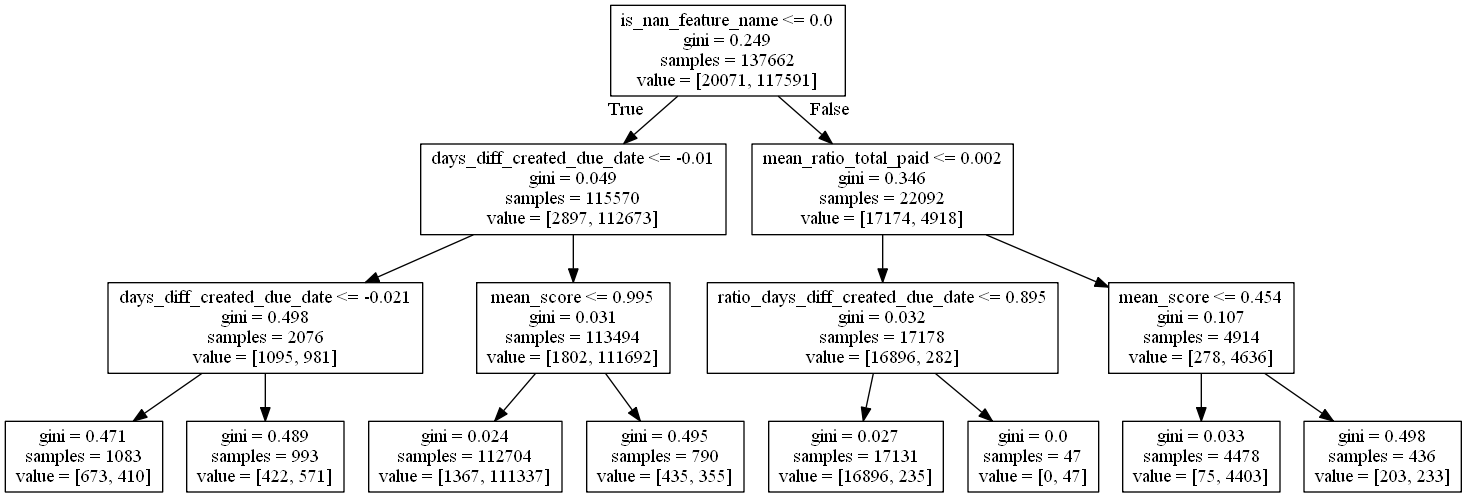

In [29]:
from IPython.display import Image
import subprocess
import os

PNG_FILE = 'dt.png'
DOT_FILE = 'dt.dot'
PATH_TO_DOT = os.getcwd() + '\\graphviz-2.38\\bin\\'

def visualize_tree(tree, feature_names):
    with open(DOT_FILE, 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = [PATH_TO_DOT + 'dot', '-Tpng', DOT_FILE, '-o', PNG_FILE]
    try:
        subprocess.check_call(command)
    except:
        print("Could not run dot, ie graphviz, to "
             "produce visualization")
        
visualize_tree(dtc, vectorizer.feature_names_)
Image(PNG_FILE)


# Regression

### basic error level

In [30]:
data_overdue_dur = (data['last_payment_date'] - data['due']).astype('timedelta64[D]')
median_overdue_dur = data_overdue_dur[data_overdue_dur > 0].median()

In [31]:
median_absolute_error(overdue_duration, [median_overdue_dur] * len(overdue_duration))

11.0

## building regression models

In [32]:
features_regress_vect = vectorizer.transform(features_regress)

### LinearRegression

In [34]:
lr = LinearRegression()

cv_score = cross_val_score(lr, features_regress_vect, overdue_duration, 
                           scoring='neg_median_absolute_error', cv=5)

'MedianAE score: {:.3f}, std: {:.3f}'.format(np.mean(cv_score), np.std(cv_score))

'MedianAE score: -9.090, std: 0.321'

### RandomForestRegressor

In [35]:
rfr = RandomForestRegressor(random_state=0)
cv_score = cross_val_score(rfr, features_regress_vect, overdue_duration, 
                           scoring='neg_median_absolute_error', cv=5)

'MedianAE score: {:.3f}, std: {:.3f}'.format(np.mean(cv_score), np.std(cv_score))

'MedianAE score: -4.500, std: 0.190'

In [36]:
rfr.fit(features_regress_vect, overdue_duration)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [37]:
i = 1125
'Real: {:.3f}, Predicted: {:.3f}'.format(overdue_duration[i], rfr.predict(features_regress_vect[i])[0])

'Real: 20.000, Predicted: 18.300'

In [58]:
x / 100.0 * 30

30.0

# Predictive model

In [76]:
SINGLE_INVOICE_FEATURES = ['days_diff_created_due_date', 'mean_score', 'paid_status', 'overdue', 'overdue_duration']

def check_if_single_entry(f):
    def wrapped(x):
        if x.shape[0] == 1:
            features_names = SINGLE_INVOICE_FEATURES
        else:
            features_names = list(features_funcs.keys())
        return f(x, features_names)
    return wrapped


@check_if_single_entry
def features_calculator(data, features_names):
    features = dict((name, func(data)) for name, func in features_funcs.items() if name in features_names)
    if features_names != SINGLE_INVOICE_FEATURES:
        features['is_nan_feature_name'] = np.nan in features.values()
    return features


PENALTY = 100.0
FINE_PERIOD = {
    'SHORT': {
        'Duration': 7.0,
        'Percents': 10.0
    },
    'LONG': {
        'Duration': 30.0,
        'Percents': 20.0
    },
}

def loss_calculator(overdue_dur, total):
    if overdue_dur < FINE_PERIOD['SHORT']['Duration']:
        return total / 100.0 * FINE_PERIOD['SHORT']['Percents'] + PENALTY
    else:
        fine_level = overdue_dur // FINE_PERIOD['LONG']['Duration'] + 1
        return fine_level * (total / 100.0 * FINE_PERIOD['LONG']['Percents']) + PENALTY
    

def predictor(input, data, vectorizer, classifier, regressor):
    # appending with historical data
    cust_data = pd.concat([data[data['customer_id'].isin(list(input['customer_id']))], input])
    
    print(cust_data)
    
    # calculating features
    input_features = features_calculator(cust_data)
    
    
    input_features = extract_targets([input_features])[0]
    
    features_vect = vectorizer.transform(input_features)
    features_norm = normalize(features_vect, norm='l1', axis=1)
    
    
    # predicting
    is_overdue = classifier.predict(features_norm)[0]
    
    res = dict(overdue=is_overdue)
    if is_overdue:
        overdue_dur = np.round(regressor.predict(features_vect)[0])
        overdue_date = input['due'].iloc[0] + pd.DateOffset(days=overdue_dur)
        losses = loss_calculator(overdue_dur, input['total'].iloc[0])
        res.update(dict(overdue_dur=overdue_dur,
                        payment_at=overdue_date, 
                        losses=losses,
                        total_sum_to_pay=input['total'].iloc[0] + losses))
    return res

In [77]:
input = pd.DataFrame.from_dict({4951234: {
     'customer_id': 1857271, 
     'created_at': '2017-07-18 10:14:02', 
     'due': '2017-07-21 00:00:00', 
     'last_payment_date': pd.NaT, 
     'paid_status': '', 
     'total': 120.0, 
     'paid': np.nan, 
     'tax': 0.0, 
     'currency': 'USD', 
     'exchange_rate': 1.0, 
     'source_system': 'FTP', 
     'description': 'company_name Premier Dealer - New Country Ford', 
     'created_at_cust': '2017-11-09 15:20:25', 
     'score': 90}}).T

for col in ['created_at', 'due', 'last_payment_date', 'created_at_cust']:
    input[col] = pd.to_datetime(input[col], errors='coerce')

print(predictor(input, data, vectorizer, rfc, rfr))

                 created_at     created_at_cust currency customer_id  \
3008727 2016-01-08 18:34:10 2017-11-09 15:20:25      USD     1857271   
3076422 2016-02-07 11:15:13 2017-11-09 15:20:25      USD     1857271   
3058977 2016-03-14 15:54:10 2017-11-09 15:20:25      USD     1857271   
3064452 2016-04-11 08:59:13 2017-11-09 15:20:25      USD     1857271   
3011492 2016-05-15 15:29:15 2017-11-09 15:20:25      USD     1857271   
3017877 2016-06-12 16:13:44 2017-11-09 15:20:25      USD     1857271   
3032351 2016-07-14 10:50:54 2017-11-09 15:20:25      USD     1857271   
3068078 2016-08-07 16:35:43 2017-11-09 15:20:25      USD     1857271   
3037807 2016-09-13 14:58:18 2017-11-09 15:20:25      USD     1857271   
3024128 2016-09-13 15:24:08 2017-11-09 15:20:25      USD     1857271   
3017038 2016-10-10 10:03:14 2017-11-09 15:20:25      USD     1857271   
3091541 2016-11-09 09:49:28 2017-11-09 15:20:25      USD     1857271   
3501701 2016-12-06 13:54:57 2017-11-09 15:20:25      USD     185

In [78]:
input = pd.DataFrame.from_dict({4951235: {
     'customer_id': 1856263, 
     'created_at': '2017-04-01 11:24:45', 
     'due': '2017-04-02', 
     'last_payment_date': pd.NaT, 
     'paid_status': '', 
     'total': 32401.0, 
     'paid': np.nan, 
     'tax': 0.0, 
     'currency': 'USD', 
     'exchange_rate': 1.0, 
     'source_system': 'FTP', 
     'description': 'company_name Premier Dealer - Richmond BMW', 
     'created_at_cust': '2017-11-09 15:20:25', 
     'score': 90}}).T

for col in ['created_at', 'due', 'last_payment_date', 'created_at_cust']:
    input[col] = pd.to_datetime(input[col], errors='coerce')

print(predictor(input, data, vectorizer, rfc, rfr))

                 created_at     created_at_cust currency customer_id  \
3003479 2016-01-12 12:48:29 2017-11-09 15:20:25      USD     1856263   
3042757 2016-01-12 12:54:14 2017-11-09 15:20:25      USD     1856263   
3034474 2016-02-07 14:27:21 2017-11-09 15:20:25      USD     1856263   
3082871 2016-02-07 14:27:21 2017-11-09 15:20:25      USD     1856263   
3009732 2016-02-07 14:32:13 2017-11-09 15:20:25      USD     1856263   
3000708 2016-02-07 14:32:13 2017-11-09 15:20:25      USD     1856263   
3025867 2016-03-10 11:14:30 2017-11-09 15:20:25      USD     1856263   
3057799 2016-03-10 11:14:30 2017-11-09 15:20:25      USD     1856263   
3080260 2016-03-10 11:32:58 2017-11-09 15:20:25      USD     1856263   
3067899 2016-03-10 11:37:43 2017-11-09 15:20:25      USD     1856263   
3006607 2016-03-10 11:37:43 2017-11-09 15:20:25      USD     1856263   
3053397 2016-03-10 14:18:35 2017-11-09 15:20:25      USD     1856263   
3066367 2016-03-13 10:10:55 2017-11-09 15:20:25      USD     185




# PLOTS

In [280]:
is_unpaid = data.groupby('customer_id').agg({'score': max, 
                                   'paid_status': lambda x: 1 * (np.sum(x == 'UNPAID') > 0) + np.random.randn(1) * 0.05})

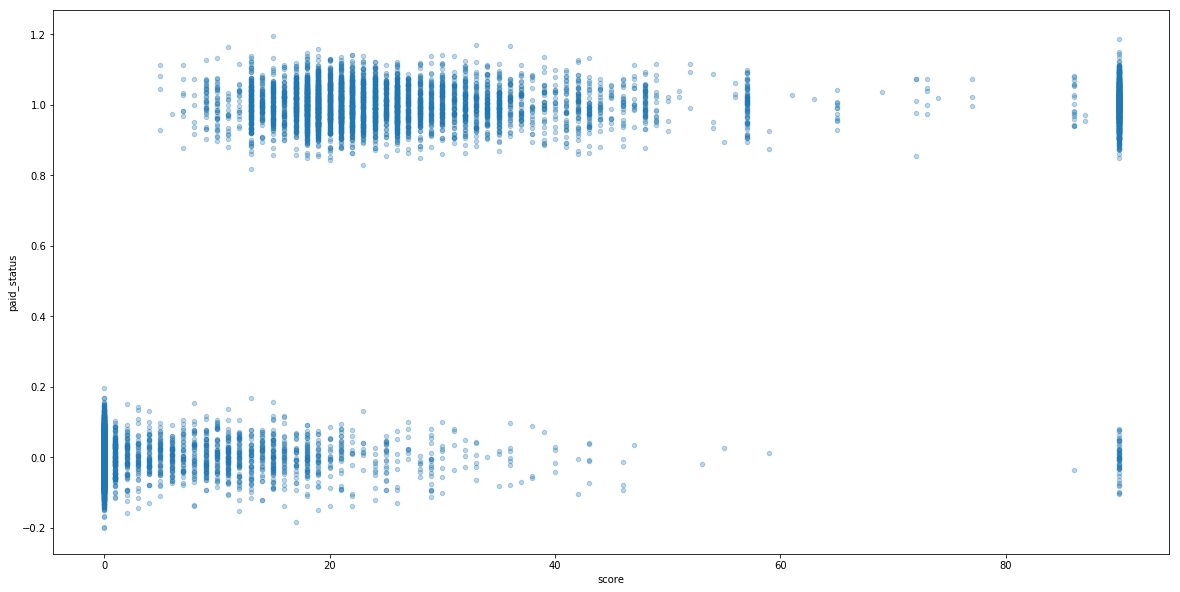

In [281]:
is_unpaid.plot.scatter(x='score', y='paid_status', alpha=0.3, figsize=(20, 10))

In [282]:
number_unpaids = data.groupby('customer_id').agg({'score': max, 'paid_status': lambda x: np.sum(x == 'UNPAID')})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132FFF90>,
      dtype=object)

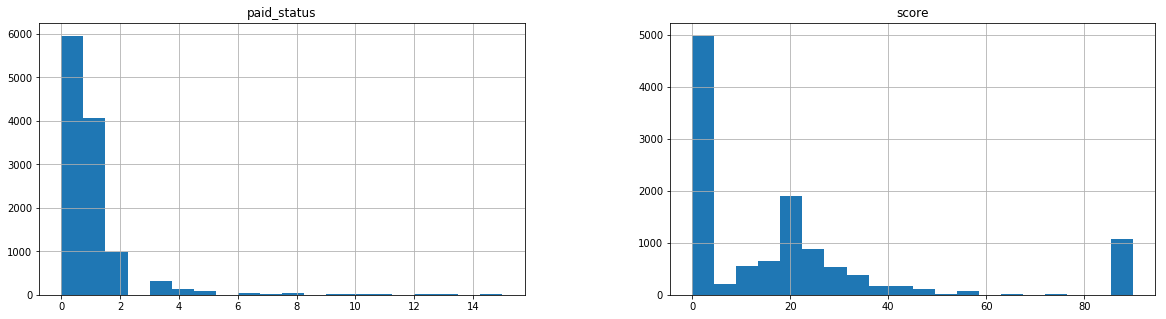

In [284]:
number_unpaids.hist(bins=20, figsize=(20, 5))

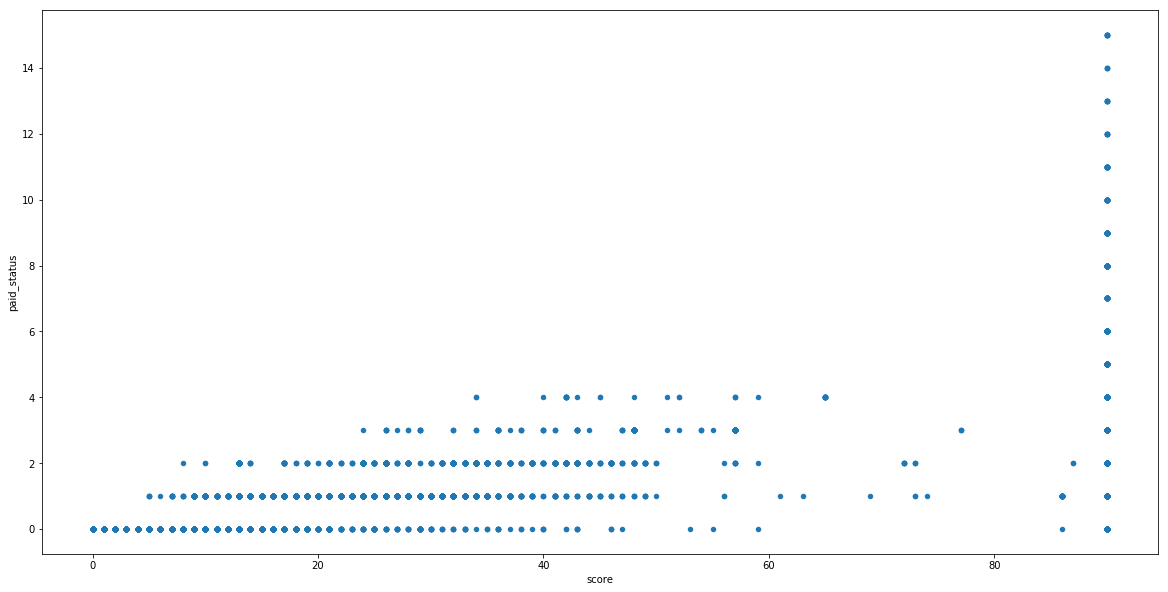

In [285]:
number_unpaids.plot.scatter(x='score', y='paid_status', figsize=(20,10))

In [288]:
n_customers = data['customer_id'].unique().size

In [289]:
number_unpaids[number_unpaids['paid_status'] > 1].size / n_customers

0.29000341180484474

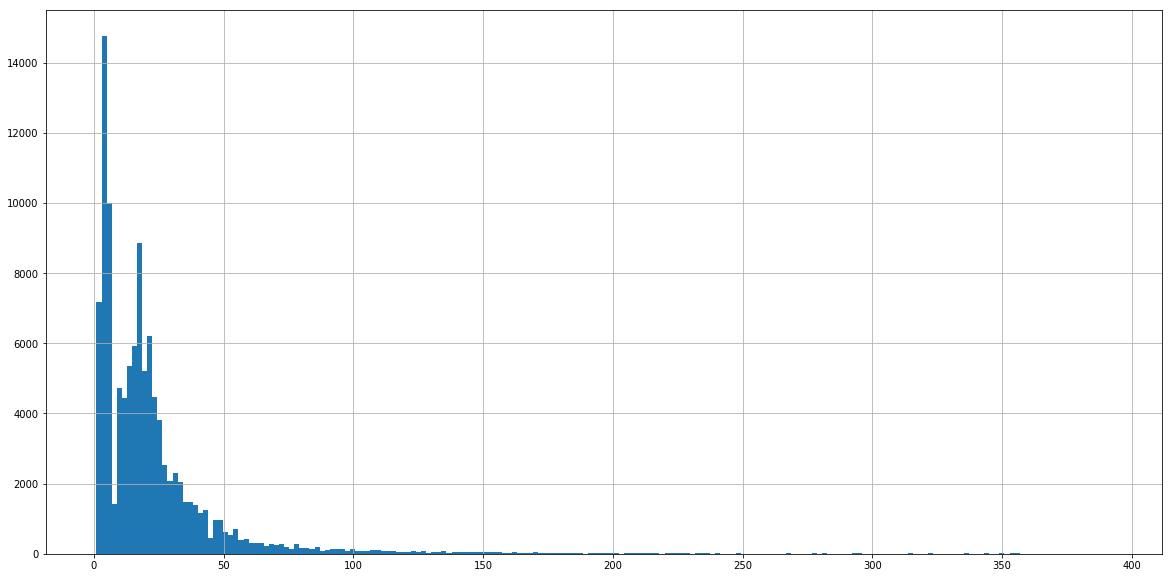

In [286]:
data_overdue_dur = (data['last_payment_date'] - data['due']).astype('timedelta64[D]')
data_overdue_dur[data_overdue_dur > 0].hist(bins=200, figsize=(20, 10))

In [290]:
data_overdue_dur[data_overdue_dur > 0].median()

17.0